### Weight Initialization
Having good initial weights can place the neural network close to the optimal solution. This allows the neural network to come to the best solution quicker.

### Dataset
To see how different weights perform, we'll test on the same dataset and neural network. Let's go over the dataset and neural network.

We'll be using the MNIST dataset to demonstrate the different initial weights. As a reminder, the MNIST dataset contains images of handwritten numbers, 0-9, with normalized input (0.0 - 1.0). Run the cell below to download and load the MNIST dataset.

In [16]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
%matplotlib inline

In [15]:
print('Getting MNIST Dataset...')
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
print('Data Extracted.')

Getting MNIST Dataset...
Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Data Extracted.


### define helper function

In [17]:
def _get_loss_acc(dataset, weights):
    """
    Get losses and validation accuracy of example neural network
    """
    batch_size = 128
    epochs = 2
    learning_rate = 0.001

    features = tf.placeholder(tf.float32)
    labels = tf.placeholder(tf.float32)
    learn_rate = tf.placeholder(tf.float32)

    biases = [
        tf.Variable(tf.zeros([256])),
        tf.Variable(tf.zeros([128])),
        tf.Variable(tf.zeros([dataset.train.labels.shape[1]]))
    ]

    # Layers
    layer_1 = tf.nn.relu(tf.matmul(features, weights[0]) + biases[0])
    layer_2 = tf.nn.relu(tf.matmul(layer_1, weights[1]) + biases[1])
    logits = tf.matmul(layer_2, weights[2]) + biases[2]

    # Training loss
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels))

    # Optimizer
    optimizer = tf.train.AdamOptimizer(learn_rate).minimize(loss)

    # Accuracy
    correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(labels, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    # Measurements use for graphing loss
    loss_batch = []

    with tf.Session() as session:
        session.run(tf.global_variables_initializer())
        batch_count = int((dataset.train.num_examples / batch_size))

        # The training cycle
        for epoch_i in range(epochs):
            for batch_i in range(batch_count):
                batch_features, batch_labels = dataset.train.next_batch(batch_size)

                # Run optimizer and get loss
                session.run(
                    optimizer,
                    feed_dict={features: batch_features, labels: batch_labels, learn_rate: learning_rate})
                l = session.run(
                    loss,
                    feed_dict={features: batch_features, labels: batch_labels, learn_rate: learning_rate})
                loss_batch.append(l)

        valid_acc = session.run(
            accuracy,
            feed_dict={features: dataset.validation.images, labels: dataset.validation.labels, learn_rate: 1.0})

    # Hack to Reset batches
    dataset.train._index_in_epoch = 0
    dataset.train._epochs_completed = 0

    return loss_batch, valid_acc


def compare_init_weights(
        dataset,
        title,
        weight_init_list,
        plot_n_batches=100):
    """
    Plot loss and print stats of weights using an example neural network
    """
    colors = ['r', 'b', 'g', 'c', 'y', 'k']
    label_accs = []
    label_loss = []

    assert len(weight_init_list) <= len(colors), 'Too many inital weights to plot'

    for i, (weights, label) in enumerate(weight_init_list):
        loss, val_acc = _get_loss_acc(dataset, weights)

        plt.plot(loss[:plot_n_batches], colors[i], label=label)
        label_accs.append((label, val_acc))
        label_loss.append((label, loss[-1]))

    plt.title(title)
    plt.xlabel('Batches')
    plt.ylabel('Loss')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()

    print('After 858 Batches (2 Epochs):')
    print('Validation Accuracy')
    for label, val_acc in label_accs:
        print('  {:7.3f}% -- {}'.format(val_acc*100, label))
    print('Loss')
    for label, loss in label_loss:
        print('  {:7.3f}  -- {}'.format(loss, label))

### Neural Network

For the neural network, we'll test on a 3 layer(2 hidden layers + 1 output layer) neural network with ReLU activations and an Adam optimizer.

In [4]:
# Save the shapes of weights for each layer
layer_1_weight_shape = (mnist.train.images.shape[1], 256) # hidden 1
layer_2_weight_shape = (256, 128) # hidden 2
layer_3_weight_shape = (128, mnist.train.labels.shape[1]) # output

### Initialize Weights
Let's start looking at some initial weights.

### All Zeros or Ones
If you follow the principle of Occam's razor, you might think setting all the weights to 0 or 1 would be the best solution. This is not the case.

With every weight the same, all the neurons at each layer are producing the same output. This makes it hard to decide which weights to adjust.

Let's compare the loss with all ones and all zero weights, run two different initial weights on the neural network above for 2 epochs. 

In [5]:
all_zero_weights = [
    tf.Variable(tf.zeros(layer_1_weight_shape)),
    tf.Variable(tf.zeros(layer_2_weight_shape)),
    tf.Variable(tf.zeros(layer_3_weight_shape))
]

all_one_weights = [
    tf.Variable(tf.ones(layer_1_weight_shape)),
    tf.Variable(tf.ones(layer_2_weight_shape)),
    tf.Variable(tf.ones(layer_3_weight_shape))
]

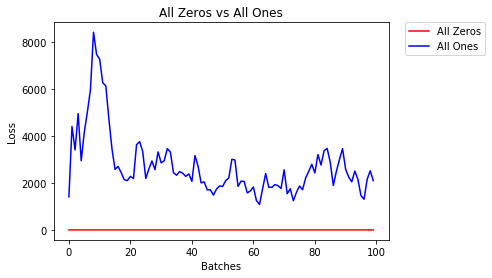

After 858 Batches (2 Epochs):
Validation Accuracy
   11.260% -- All Zeros
    9.240% -- All Ones
Loss
    2.295  -- All Zeros
  329.897  -- All Ones


In [18]:
compare_init_weights(
    mnist,
    'All Zeros vs All Ones',
    [
        (all_zero_weights, 'All Zeros'),
        (all_one_weights, 'All Ones')])

As you can see the accuracy is close to guessing for both zeros and ones, around 10%.

The neural network is having a hard time determining which weights need to be changed, since **the neurons have the same output for each layer**. To avoid neurons with the same output, let's use unique weights. We can also randomly select these weights to avoid being stuck in a local minimum for each run.

A good solution for getting these random weights is to sample from a uniform distribution.


### Uniform Distribution

A uniform distribution has the equal probability of picking any number from a set of numbers. We'll be picking from a continous distribution, so the chance of picking the same number is low. We'll use TensorFlow's tf.random_uniform function to pick random numbers from a uniform distribution.

Let's see how well the neural network trains using the default values for tf.random_uniform, where minval=0.0 and maxval=1.0.

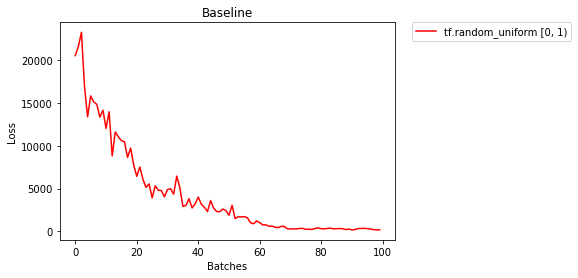

After 858 Batches (2 Epochs):
Validation Accuracy
   84.820% -- tf.random_uniform [0, 1)
Loss
   12.772  -- tf.random_uniform [0, 1)


In [20]:
# Default for tf.random_uniform is minval=0 and maxval=1
basline_weights = [
    tf.Variable(tf.random_uniform(layer_1_weight_shape)),
    tf.Variable(tf.random_uniform(layer_2_weight_shape)),
    tf.Variable(tf.random_uniform(layer_3_weight_shape))
]

compare_init_weights(
    mnist,
    'Baseline',
    [(basline_weights, 'tf.random_uniform [0, 1)')])


The loss graph is showing the neural network is learning, which it didn't with all zeros or all ones. We're headed in the right direction.

### General rule for setting weights
The general rule for setting the weights in a neural network is to be close to zero without being too small. A good pracitce is to start your weights in the range of $[-y, y]$ where $y=1/\sqrt{n}$ ($n$ is the number of inputs to a given neuron).
Let's see if this holds true, let's first center our range over zero. This will give us the range [-1, 1).

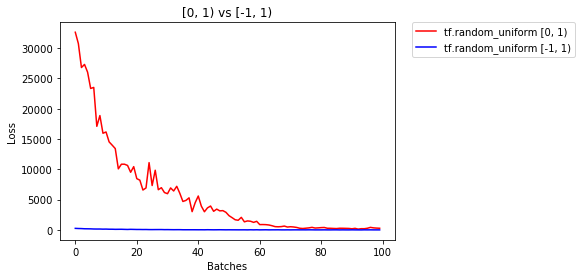

After 858 Batches (2 Epochs):
Validation Accuracy
   81.100% -- tf.random_uniform [0, 1)
   90.100% -- tf.random_uniform [-1, 1)
Loss
   13.883  -- tf.random_uniform [0, 1)
    3.150  -- tf.random_uniform [-1, 1)


In [21]:
uniform_neg1to1_weights = [
    tf.Variable(tf.random_uniform(layer_1_weight_shape, -1, 1)),
    tf.Variable(tf.random_uniform(layer_2_weight_shape, -1, 1)),
    tf.Variable(tf.random_uniform(layer_3_weight_shape, -1, 1))
]

compare_init_weights(
    mnist,
    '[0, 1) vs [-1, 1)',
    [
        (basline_weights, 'tf.random_uniform [0, 1)'),
        (uniform_neg1to1_weights, 'tf.random_uniform [-1, 1)')])

We're going in the right direction, the accuracy and loss is better with [-1, 1). We still want smaller weights. How far can we go before it's too small?

### Too small

Let's compare [-0.1, 0.1), [-0.01, 0.01), and [-0.001, 0.001) to see how small is too small. We'll also set plot_n_batches=None to show all the batches in the plot.

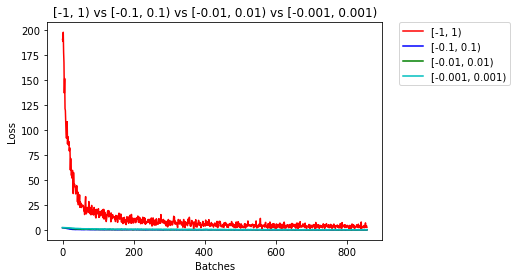

After 858 Batches (2 Epochs):
Validation Accuracy
   90.040% -- [-1, 1)
   96.640% -- [-0.1, 0.1)
   95.780% -- [-0.01, 0.01)
   92.640% -- [-0.001, 0.001)
Loss
    2.591  -- [-1, 1)
    0.053  -- [-0.1, 0.1)
    0.115  -- [-0.01, 0.01)
    0.334  -- [-0.001, 0.001)


In [24]:
uniform_neg01to01_weights = [
    tf.Variable(tf.random_uniform(layer_1_weight_shape, -0.1, 0.1)),
    tf.Variable(tf.random_uniform(layer_2_weight_shape, -0.1, 0.1)),
    tf.Variable(tf.random_uniform(layer_3_weight_shape, -0.1, 0.1))
]

uniform_neg001to001_weights = [
    tf.Variable(tf.random_uniform(layer_1_weight_shape, -0.01, 0.01)),
    tf.Variable(tf.random_uniform(layer_2_weight_shape, -0.01, 0.01)),
    tf.Variable(tf.random_uniform(layer_3_weight_shape, -0.01, 0.01))
]

uniform_neg0001to0001_weights = [
    tf.Variable(tf.random_uniform(layer_1_weight_shape, -0.001, 0.001)),
    tf.Variable(tf.random_uniform(layer_2_weight_shape, -0.001, 0.001)),
    tf.Variable(tf.random_uniform(layer_3_weight_shape, -0.001, 0.001))
]

compare_init_weights(
    mnist,
    '[-1, 1) vs [-0.1, 0.1) vs [-0.01, 0.01) vs [-0.001, 0.001)',
    [
        (uniform_neg1to1_weights, '[-1, 1)'),
        (uniform_neg01to01_weights, '[-0.1, 0.1)'),
        (uniform_neg001to001_weights, '[-0.01, 0.01)'),
        (uniform_neg0001to0001_weights, '[-0.001, 0.001)')],
    plot_n_batches=None)

Looks like anything [-0.01, 0.01) or smaller is too small. Let's compare this to our typical rule of using the range $y=1/\sqrt{n}$.

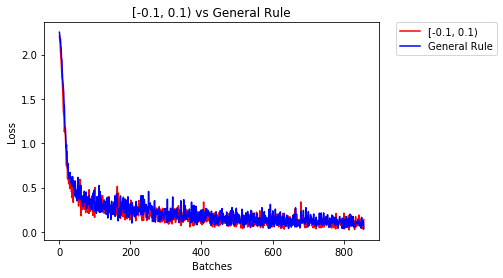

After 858 Batches (2 Epochs):
Validation Accuracy
   97.160% -- [-0.1, 0.1)
   97.060% -- General Rule
Loss
    0.140  -- [-0.1, 0.1)
    0.042  -- General Rule


In [27]:
import numpy as np

general_rule_weights = [
    tf.Variable(tf.random_uniform(layer_1_weight_shape, -1/np.sqrt(layer_1_weight_shape[0]), 1/np.sqrt(layer_1_weight_shape[0]))),
    tf.Variable(tf.random_uniform(layer_2_weight_shape, -1/np.sqrt(layer_2_weight_shape[0]), 1/np.sqrt(layer_2_weight_shape[0]))),
    tf.Variable(tf.random_uniform(layer_3_weight_shape, -1/np.sqrt(layer_3_weight_shape[0]), 1/np.sqrt(layer_3_weight_shape[0])))
]

compare_init_weights(
    mnist,
    '[-0.1, 0.1) vs General Rule',
    [
        (uniform_neg01to01_weights, '[-0.1, 0.1)'),
        (general_rule_weights, 'General Rule')],
    plot_n_batches=None)

Since the uniform distribution has the same chance to pick anything in the range, what if we used a distribution that had a higher chance of picking numbers closer to 0. Let's look at the normal distribution.


### Normal Distribution

Unlike the uniform distribution, the normal distribution has a higher likelihood of picking number close to it's mean. 

Let's compare the normal distribution against the previous uniform distribution.

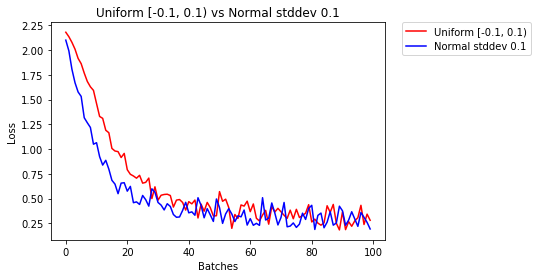

After 858 Batches (2 Epochs):
Validation Accuracy
   96.760% -- Uniform [-0.1, 0.1)
   96.580% -- Normal stddev 0.1
Loss
    0.102  -- Uniform [-0.1, 0.1)
    0.049  -- Normal stddev 0.1


In [28]:
normal_01_weights = [
    tf.Variable(tf.random_normal(layer_1_weight_shape, stddev=0.1)),
    tf.Variable(tf.random_normal(layer_2_weight_shape, stddev=0.1)),
    tf.Variable(tf.random_normal(layer_3_weight_shape, stddev=0.1))
]

compare_init_weights(
    mnist,
    'Uniform [-0.1, 0.1) vs Normal stddev 0.1',
    [
        (uniform_neg01to01_weights, 'Uniform [-0.1, 0.1)'),
        (normal_01_weights, 'Normal stddev 0.1')])

The normal distribution gave a slight increasse in accuracy and loss. Let's move closer to 0 and drop picked numbers that are x number of standard deviations away. This distribution is called Truncated Normal Distribution.

### Truncated Normal Distribution

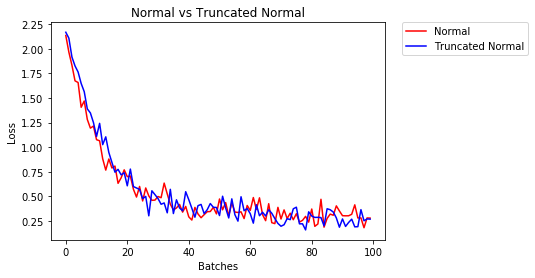

After 858 Batches (2 Epochs):
Validation Accuracy
   97.220% -- Normal
   97.220% -- Truncated Normal
Loss
    0.069  -- Normal
    0.048  -- Truncated Normal


In [30]:
trunc_normal_01_weights = [
    tf.Variable(tf.truncated_normal(layer_1_weight_shape, stddev=0.1)),
    tf.Variable(tf.truncated_normal(layer_2_weight_shape, stddev=0.1)),
    tf.Variable(tf.truncated_normal(layer_3_weight_shape, stddev=0.1))
]

compare_init_weights(
    mnist,
    'Normal vs Truncated Normal',
    [
        (normal_01_weights, 'Normal'),
        (trunc_normal_01_weights, 'Truncated Normal')])

There's no difference between the two, but that's because the neural network we're using is too small. A larger neural network will pick more points on the normal distribution, increasing the likelihood it's choices are larger than 2 standard deviations.